In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.ndimage import label

In [3]:
# Define parameters

grid_size = (50, 50)
np.random.seed(123)
criminality = np.random.rand(*grid_size) # Define the initial criminality for every cell
education = np.random.rand(*grid_size) # Define the education for every cell (here fixed, but can be linked to data in final model)
income = np.random.rand(*grid_size) # Define the income for every cell (here fixed, but can be linked to data in final model)
alpha = 0.3 # Assign weight for influence of criminality in own neighbourhood
beta = 1 - alpha # Assign weight for influence of criminality in other neighbourhoods 
influence_diff = 0 # Assign weight for difference in influence of "bad" neighbourhoods compared to "good" neighbourhoods
percolation_threshold = 0.5 # Define the percolation threshold to later calculate the giant component
police_threshold = 0.7 # Set the threshold of criminality for police intervention
police_effect = 0.3 # Decide by how much criminality is reduced in a cell when police acts
redistribution_frac = 0.7 # Decide how much of the criminality is redistributed to neighbouring cells
police_units = 15 # Define the number of available police units

In [3]:
'''
states  = [0, 0.5, 1]
criminality = np.random.choice(states, size=grid_size)
'''

'\nstates  = [0, 0.5, 1]\ncriminality = np.random.choice(states, size=grid_size)\n'

In the following cell, we set up the model such that, in each time period, we update the criminality level $C$ of each cell based on the transition function:

$$ C_{t+1} =  \alpha C_t + (\beta (1 - \gamma)) M + \frac{\beta}{2} L$$

where:
- $\alpha$ controls the sensitivity of the new level of criminality to the cell-self old criminality;
- $\beta$ controls the sensitivity to the neighbors situation;
- $\gamma$ calibrates the dependence of sensitivity to neighbors based on education and income;
- $M$ represents the mean criminality of neighbors with more criminality than the cell of interest;
- $L$ the ones with less criminality.

This distinction (between $M$ and $L$) is necessary, since a higher education/income should reduce the sensitivity to higher criminality, but not to lower.
$\beta$ is scaled by $\frac{1}{2}$ to make it comparable on average to $\beta (1 - \gamma)$.

In [4]:
# Define functions to run simulation

def update_cell(x, y, criminality, education, income, influence_diff): # Update the criminality of a cell based on its neighbours and itself

    current_state = criminality[x, y]
    neighbors = criminality[max(0, x-1):x+2, max(0,y-1):y+2] # Get the 8 neighbours of the cell
    neighbors = np.delete(neighbors, (neighbors.shape[0] // 2, neighbors.shape[1] // 2)) # Remove the cell itself from the neighbours

    # Here we distinguish between neighbours with more criminality and neighbours with less criminality
    less_crim_influence = np.mean(neighbors[neighbors <= current_state]) if np.any(neighbors <= current_state) else 0
    more_crim_influence = np.mean(neighbors[neighbors > current_state]) if np.any(neighbors > current_state) else 0

    gamma = np.mean([education[x, y], income[x, y]]) # Here we calculate the average sensitivity of the cell to "external" criminality, so that higher education/income result in lower sensitivity (following line)

    # Here we calculate the influence of neighbors distinguishing between more and less criminality (compared to the cell itself) because higher education/income should lower the sensitivity to more criminality but not to less criminality
    weight_more = (beta * np.clip(1 - gamma, 0.1, 0.9)) + influence_diff # We clip the value to avoid the weight to be 0
    weight_less = (beta / 2) - influence_diff

    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours
    new_state = (
        alpha * current_state +
        weight_more * more_crim_influence +
        weight_less * less_crim_influence
    )
    return np.clip(new_state, 0, 1)

def update_grid_nopolice(criminality, education, income, influence_diff): # Update the criminality of the whole grid based on the update_cell function

    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell(x, y, criminality, education, income, influence_diff)
    
    return new_criminality

def update_cell_withbuildup(x, y, criminality, education, income, influence_diff, buildup): # Update the criminality of a cell based on its neighbours and itself

    current_state = criminality[x, y]
    neighbors = criminality[max(0, x-1):x+2, max(0,y-1):y+2] # Get the 8 neighbours of the cell
    neighbors = np.delete(neighbors, (neighbors.shape[0] // 2, neighbors.shape[1] // 2)) # Remove the cell itself from the neighbours

    # Here we distinguish between neighbours with more criminality and neighbours with less criminality
    less_crim_influence = np.mean(neighbors[neighbors <= current_state - buildup]) if np.any(neighbors <= current_state) else 0
    more_crim_influence = np.mean(neighbors[neighbors > current_state + buildup]) if np.any(neighbors > current_state) else 0

    gamma = np.mean([education[x, y], income[x, y]]) # Here we calculate the average sensitivity of the cell to "external" criminality, so that higher education/income result in lower sensitivity (following line)

    # Here we calculate the influence of neighbors distinguishing between more and less criminality (compared to the cell itself) because higher education/income should lower the sensitivity to more criminality but not to less criminality
    weight_more = (beta * np.clip(1 - gamma, 0.1, 0.9)) + influence_diff # We clip the value to avoid the weight to be 0
    weight_less = (beta / 2) - influence_diff

    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours
    new_state = (
        alpha * current_state +
        weight_more * more_crim_influence +
        weight_less * less_crim_influence
    )
    return np.clip(new_state, 0, 1)

def update_grid_nopolice_withbuildup(criminality, education, income, influence_diff, buildup): # Update the criminality of the whole grid based on the update_cell function

    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell_withbuildup(x, y, criminality, education, income, influence_diff, buildup)
    
    return new_criminality

def update_grid_withpolice(criminality, education, income, influence_diff, police_threshold, police_effect, redistribution_frac, police_units): # Update the criminality of the whole grid based on the update_cell function and police intervention

    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell(x, y, criminality, education, income, influence_diff)

    new_criminality, mask = police(new_criminality, police_threshold, police_effect, redistribution_frac, police_units) # Apply police intervention and save the mask grid to visualize the intervention
    
    return new_criminality, mask

def giant_component(criminality, percolation_threshold): # Compute the size of the giant component in the criminality grid (as fraction of the grid size)

    perc_cells = criminality >= percolation_threshold # Output the grid with True value for cells with criminality above the percolation threshold
    labeled_crim, num_features = label(perc_cells) # Label the connected components in the grid (every cluster of connected cells gets a unique label)

    components = np.bincount(labeled_crim.ravel()) # Count the number of cells in each connected component
    giant_component = np.max(components[1:]) if len(components) > 1 else 0 # Get the size of the largest connected component

    return giant_component / criminality.size

def police(criminality, police_threshold, police_effect, redistribution_frac, police_units): # Apply police intervention to the criminality grid

    criminality_copy = criminality.copy()
    mask = np.zeros_like(criminality, dtype=bool) # Generate an equal grid to save location of police interventions to visualize later

    police_candidates = np.argwhere(criminality > police_threshold) # Get the coordinates of cells with criminality above the police threshold
    police_candidates = sorted(police_candidates, key=lambda x: criminality[x[0], x[1]], reverse=True) # Sort the cells by descending criminality

    interventions = police_candidates[:police_units] # Select the cells where police will act based on the number of available police units

    for x, y in interventions:
        mask[x, y] = True
        criminality_copy[x, y] = np.clip(criminality[x, y] - police_effect, 0, 1) # Reduce the criminality of the cell by the police effect

        neighbors_x = range(max(0, x-1), min(grid_size[0], x+2))
        neighbors_y = range(max(0, y-1), min(grid_size[1], y+2))

        # Redistribute the criminality of the cell to its neighbours according to the redistribution fraction
        for nx in neighbors_x:
            for ny in neighbors_y:
                if (nx, ny) == (x, y):
                    continue
                criminality_copy[nx, ny] += (police_effect * redistribution_frac) / (len(neighbors_x) * len(neighbors_y) - 1)
    
    return criminality_copy, mask

def detect_avelanche(criminality, new_criminality, threshold): # Detect if an avelanche happened in the grid

    diff = np.abs(new_criminality - criminality)
    affected_cells = diff > threshold # Get the cells where the difference in criminality is above the threshold

    labeled_avalanches, num_features = label(affected_cells) # Label the avelanches

    avalanche_sizes = np.bincount(labeled_avalanches.ravel())[1:] # Count the number of cells in each avelanche

    return avalanche_sizes, labeled_avalanches

def track_avalanches(criminality, education, income, influence_diff, time_steps, threshold):

    all_avelanches_sizes = []
    for step in range(time_steps): # In each time step, update the grid and detect avelanches and their sizes
        new_criminality = update_grid_nopolice(criminality, education, income, influence_diff)
        avalanche_sizes, labeled_avalanches = detect_avelanche(criminality, new_criminality, threshold)
        all_avelanches_sizes.extend(avalanche_sizes)
        criminality = new_criminality.copy()

    return all_avelanches_sizes

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

def update_grid_nopolice(criminality, education, income, influence_diff, alpha=0.3, beta=0.7):
    padded_crim = np.pad(criminality, pad_width=1, mode='constant', constant_values=np.nan)
    neighborhoods = sliding_window_view(padded_crim, (3, 3))
    neighbors = neighborhoods.reshape(*criminality.shape, 9)
    neighbors = np.delete(neighbors, 4, axis=2) 
    
    current = criminality[..., np.newaxis]
    
    more_mask = neighbors > current
    less_mask = neighbors <= current
    sum_more = np.nansum(neighbors * more_mask, axis=2)
    count_more = np.nansum(more_mask, axis=2)
    more_infl = np.divide(sum_more, count_more, out=np.zeros_like(sum_more), where=count_more!=0)
    
    sum_less = np.nansum(neighbors * less_mask, axis=2)
    count_less = np.nansum(less_mask, axis=2)
    less_infl = np.divide(sum_less, count_less, out=np.zeros_like(sum_less), where=count_less!=0)
    gamma = (education + income) / 2
    w_more = beta * np.clip(1 - gamma, 0.1, 0.9) + influence_diff
    w_less = beta/2 - influence_diff
    new_crim = alpha*criminality + w_more*more_infl + w_less*less_infl
    
    return np.clip(new_crim, 0, 1)

def update_grid_withpolice(criminality, education, income, influence_diff, police_threshold, police_effect, redistribution_frac, police_units):
    new_criminality = update_grid_nopolice(criminality, education, income, influence_diff)

    new_criminality, mask = police(new_criminality, police_threshold, police_effect, redistribution_frac, police_units) # Apply police intervention and save the mask grid to visualize the intervention
    
    return new_criminality, mask

In [5]:
'''
# Define functions to run simulation

def update_cell(x, y, criminality, education, income): # Update the criminality of a cell based on its neighbours nad itself

    current_state = criminality[x, y]
    neighbors = criminality[max(0, x-1):x+2, max(0,y-1):y+2] # Get the 8 neighbours of the cell
    neighbors = np.delete(neighbors, (neighbors.shape[0] // 2, neighbors.shape[1] // 2)) # Remove the cell itself from the neighbours

    # Here we distinguish between neighbours with more criminality and neighbours with less criminality
    less_crim_influence = np.mean(neighbors[neighbors <= current_state]) if np.any(neighbors <= current_state) else 0
    more_crim_influence = np.mean(neighbors[neighbors > current_state]) if np.any(neighbors > current_state) else 0

    gamma = np.mean([education[x, y], income[x, y]]) # Here we calculate the average sensitivity of the cell to "external" criminality, so that higher education/income result in lower sensitivity (following line)

    # Here we calculate the influence of neighbors distinguishing between more and less criminality (compared to the cell itself) because higher education/income should lower the sensitivity to more criminality but not to less criminality
    weight_more = beta * np.clip(1 - gamma, 0.1, 0.9) # We clip the value to avoid the weight to be 0
    weight_less = beta / 2

    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours
    new_state = (
        current_state +
        weight_more * more_crim_influence +
        weight_less * less_crim_influence
    )

    if new_state > 0.66:
        new_state = 1
    elif new_state > 0.33:
        new_state = 0.5
    else:
        new_state = 0
    
    return new_state

def update_grid(criminality, education, income): # Update the criminality of the whole grid based on the update_cell function
    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell(x, y, criminality, education, income)
    return new_criminality
'''

'\n# Define functions to run simulation\n\ndef update_cell(x, y, criminality, education, income): # Update the criminality of a cell based on its neighbours nad itself\n\n    current_state = criminality[x, y]\n    neighbors = criminality[max(0, x-1):x+2, max(0,y-1):y+2] # Get the 8 neighbours of the cell\n    neighbors = np.delete(neighbors, (neighbors.shape[0] // 2, neighbors.shape[1] // 2)) # Remove the cell itself from the neighbours\n\n    # Here we distinguish between neighbours with more criminality and neighbours with less criminality\n    less_crim_influence = np.mean(neighbors[neighbors <= current_state]) if np.any(neighbors <= current_state) else 0\n    more_crim_influence = np.mean(neighbors[neighbors > current_state]) if np.any(neighbors > current_state) else 0\n\n    gamma = np.mean([education[x, y], income[x, y]]) # Here we calculate the average sensitivity of the cell to "external" criminality, so that higher education/income result in lower sensitivity (following line)\

In [6]:
'''
# Define functions to run simulation

sensitivity = (education + income) / 2 # Define the sensitivity of every cell to criminality

def moore_neighbors(x, y, grid):

    neighbors = []
    for i in range(max(0, x - 1), min(grid.shape[0], x + 2)):
        for j in range(max(0, y - 1), min(grid.shape[1], y + 2)):
            if (i, j) != (x, y):
                neighbors.append(grid[i, j])
    return neighbors

def update_cell(x, y, criminality, education, income): # Update the criminality of a cell based on its neighbours nad itself

    current_state = criminality[x, y]
    neighbors = moore_neighbors(x, y, criminality) # Get the 8 neighbours of the cell
    diff_list = neighbors - current_state

    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours
    new_state = (
        current_state +
        (sum(diff / (1 + sensitivity[x, y]) if diff > 0 else diff for diff in diff_list)) / 8
    )
    return np.clip(new_state, 0, 1)

def update_grid(criminality, education, income): # Update the criminality of the whole grid based on the update_cell function
    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell(x, y, criminality, education, income)
    return new_criminality
'''

'\n# Define functions to run simulation\n\nsensitivity = (education + income) / 2 # Define the sensitivity of every cell to criminality\n\ndef moore_neighbors(x, y, grid):\n\n    neighbors = []\n    for i in range(max(0, x - 1), min(grid.shape[0], x + 2)):\n        for j in range(max(0, y - 1), min(grid.shape[1], y + 2)):\n            if (i, j) != (x, y):\n                neighbors.append(grid[i, j])\n    return neighbors\n\ndef update_cell(x, y, criminality, education, income): # Update the criminality of a cell based on its neighbours nad itself\n\n    current_state = criminality[x, y]\n    neighbors = moore_neighbors(x, y, criminality) # Get the 8 neighbours of the cell\n    diff_list = neighbors - current_state\n\n    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours\n    new_state = (\n        current_state +\n        (sum(diff / (1 + sensitivity[x, y]) if diff > 0 else diff for diff in diff_list)) /

In [1]:
# Run the simulation and output the results as animation

def animate(t): # Define function to use in FuncAnimation (update grid for every timestep)
    global criminality
    criminality, mask = update_grid_withpolice(criminality, education, income, influence_diff, police_threshold, police_effect, redistribution_frac, police_units)

    # Save the layer with the criminality levels
    cax.set_array(criminality)

    # Save the layer with the police intervention
    mask_layer = np.zeros((*grid_size, 4))
    mask_layer[mask] = [0, 1, 0, 1] # Set the color of the police intervention to red and set the transparency to 0.5
    overlay_cax.set_data(mask_layer)
    return cax, overlay_cax

fig, ax = plt.subplots()
cax = ax.imshow(criminality, cmap='plasma', vmin=0, vmax=1)
overlay_cax = ax.imshow(np.zeros((*grid_size, 4)))
fig.colorbar(cax, ax=ax)
ax.set_title('Criminality')

timesteps = 30

ani = FuncAnimation(fig, animate, frames=timesteps, interval=500)

HTML(ani.to_jshtml())

NameError: name 'plt' is not defined

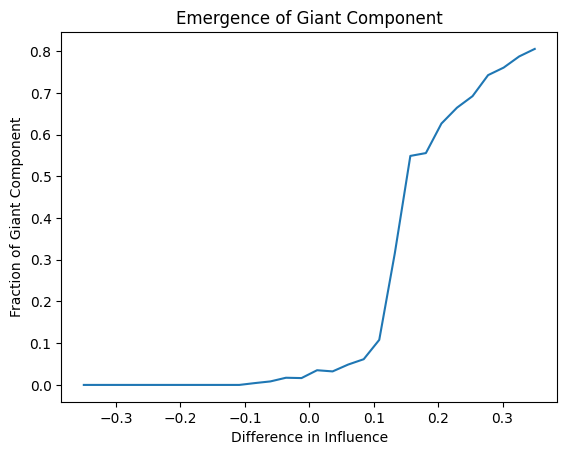

In [8]:
# Plot the size of the giant component for different values of influence difference between "good" and "bad" neighbourhoods (without police)

timesteps = 70
influence_diff_list = np.linspace(-beta/2, beta/2, 30) # Define the range of influence difference (of "bad" influence compared to the "good" one) to study the emergence of the giant component
average_giant_fractions = []
init_criminality = np.random.rand(*grid_size)

for i in range(5): # Repeat the simulation a few times to get an average curve for the emergence graph
    giant_fractions = []
    for influence_diff in influence_diff_list: # Loop through the influence difference values
        criminality = init_criminality # Reset the criminality grid
        for t in range(timesteps): # Run the simulation for a long enough time
            criminality = update_grid_nopolice(criminality, education, income,influence_diff)
        giant_fractions.append(giant_component(criminality, percolation_threshold)) # Get the size of the giant component
    average_giant_fractions.append(giant_fractions) # Store the giant component sizes for every influence difference value

average_giant_fractions = np.mean(average_giant_fractions, axis=0) # Compute the average giant component size for every influence difference value

# Plot the size of the giant component after the fixed amount of timesteps (and a fixed threshold) for every influence difference value
plt.plot(influence_diff_list, average_giant_fractions)
plt.title('Emergence of Giant Component')
plt.xlabel('Difference in Influence')
plt.ylabel('Fraction of Giant Component')
plt.show()

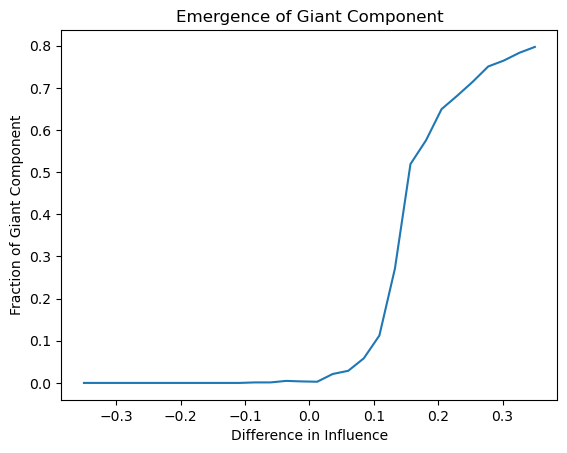

In [120]:
# Plot the size of the giant component for different values of influence difference between "good" and "bad" neighbourhoods (with police)

timesteps = 70
influence_diff_list = np.linspace(-beta/2, beta/2, 30) # Define the range of influence difference (of "bad" influence compared to the "good" one) to study the emergence of the giant component
average_giant_fractions = []
init_criminality = np.random.rand(*grid_size)

for i in range(5): # Repeat the simulation a few times to get an average curve for the emergence graph
    giant_fractions = []
    for influence_diff in influence_diff_list: # Loop through the influence difference values
        criminality = init_criminality # Reset the criminality grid
        for t in range(timesteps): # Run the simulation for a long enough time
            criminality, mask = update_grid_withpolice(criminality, education, income, influence_diff, police_threshold, police_effect, redistribution_frac, police_units)
        giant_fractions.append(giant_component(criminality, percolation_threshold)) # Get the size of the giant component
    average_giant_fractions.append(giant_fractions) # Store the giant component sizes for every influence difference value

average_giant_fractions = np.mean(average_giant_fractions, axis=0) # Compute the average giant component size for every influence difference value

# Plot the size of the giant component after the fixed amount of timesteps (and a fixed threshold) for every influence difference value
plt.plot(influence_diff_list, average_giant_fractions)
plt.title('Emergence of Giant Component')
plt.xlabel('Difference in Influence')
plt.ylabel('Fraction of Giant Component')
plt.show()

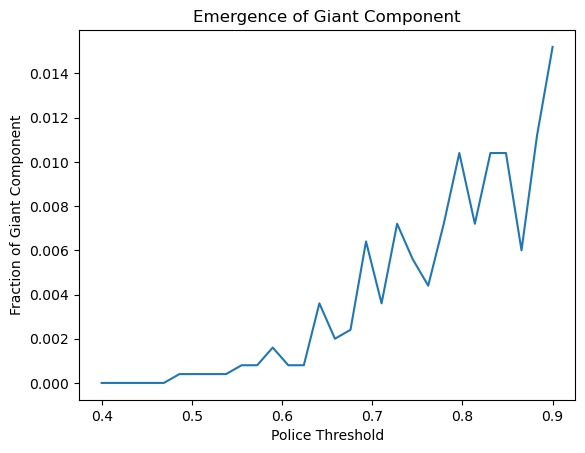

In [121]:
# Plot the size of the giant component for different values of police threshold

timesteps = 70
influence_diff = 0
police_threshold_list = np.linspace(0.4, 0.9, 30) # Define the range of police threshold values to study the emergence of the giant component
average_giant_fractions = []
init_criminality = np.random.rand(*grid_size)

for i in range(5): # Repeat the simulation a few times to get an average curve for the emergence graph
    giant_fractions = []
    for police_threshold in police_threshold_list: # Loop through the police threshold values
        criminality = init_criminality # Reset the criminality grid
        for t in range(timesteps): # Run the simulation for a long enough time
            criminality, mask = update_grid_withpolice(criminality, education, income,influence_diff, police_threshold, police_effect, redistribution_frac, police_units)
        giant_fractions.append(giant_component(criminality, percolation_threshold)) # Get the size of the giant component
    average_giant_fractions.append(giant_fractions) # Store the giant component sizes for every police threshold value

average_giant_fractions = np.mean(average_giant_fractions, axis=0) # Compute the average giant component size for every police threshold value

# Plot the size of the giant component after the fixed amount of timesteps (and a fixed threshold) for every police threshold value
plt.plot(police_threshold_list, average_giant_fractions)
plt.title('Emergence of Giant Component')
plt.xlabel('Police Threshold')
plt.ylabel('Fraction of Giant Component')
plt.show()

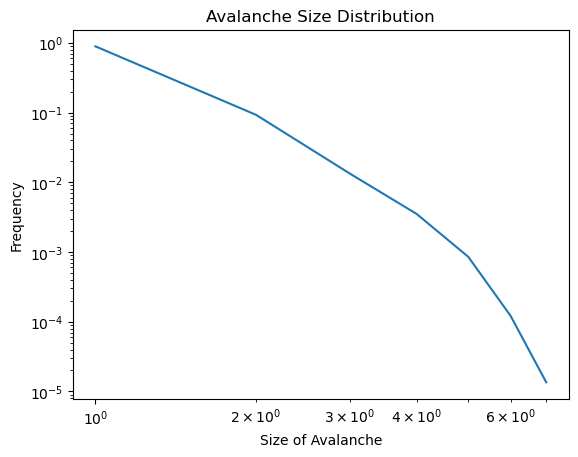

In [27]:
# Study avenache-size frequency distribution for threshold = 0.3

# Initialize the grids
criminality = np.random.rand(*grid_size)
education = np.random.rand(*grid_size)
income = np.random.rand(*grid_size)

all_avelanches_sizes = track_avalanches(criminality, education, income, influence_diff, time_steps = 3000, threshold = 0.3) # Track all the avelancehs events and their sizes
sizes, counts = np.unique(all_avelanches_sizes, return_counts=True) # Extract the size and number of events per size
frequencies = counts / np.sum(counts) # Compute the frequency of each size

plt.plot(sizes, frequencies)
plt.yscale('log')
plt.xscale('log')
plt.title('Avalanche Size Distribution')
plt.xlabel('Size of Avalanche')
plt.ylabel('Frequency')
plt.show()

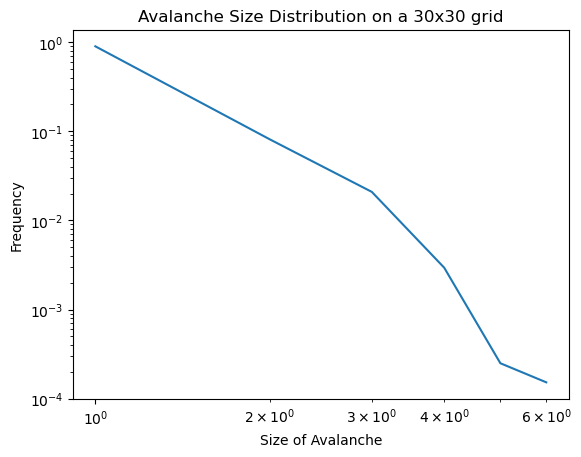

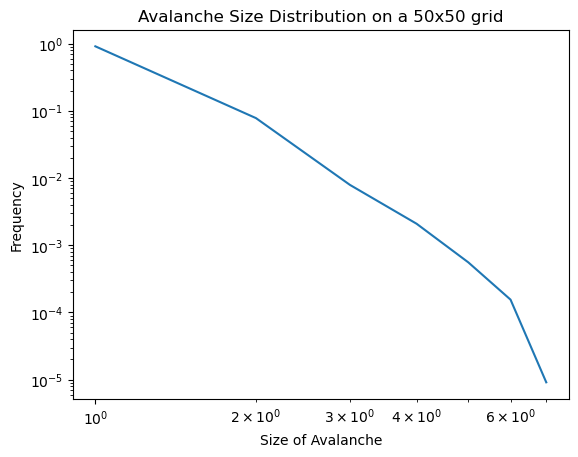

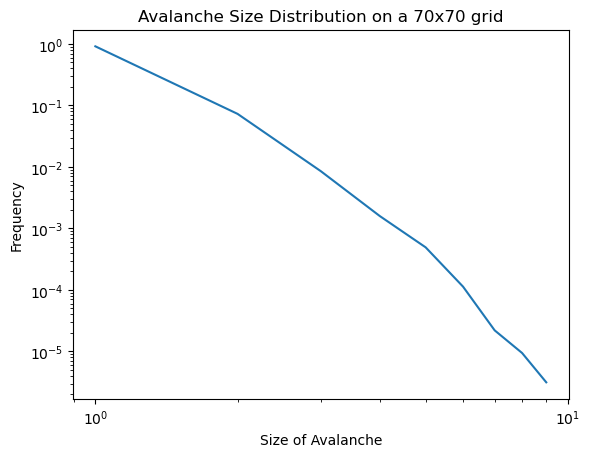

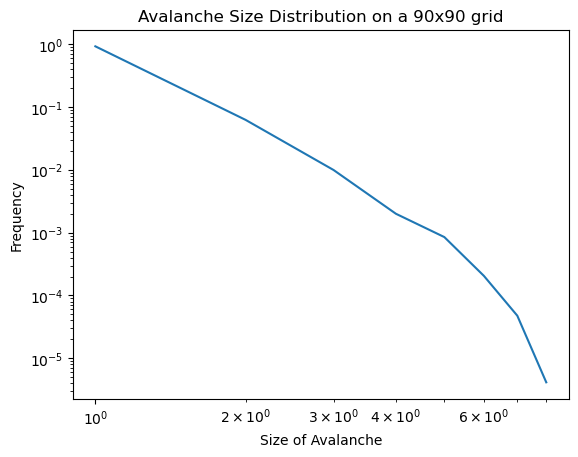

In [4]:
# Study avenache-size frequency distribution for threshold = 0.3

side_lenght = [30, 50, 70, 90]
time_steps = 4000
threshold = 0.3
all_sizes = []
all_frequencies = []

for side in side_lenght:
    grid_size = (side, side)
    # Initialize the grids
    criminality = np.random.rand(*grid_size)
    education = np.random.rand(*grid_size)
    income = np.random.rand(*grid_size)

    all_avelanches_sizes = track_avalanches(criminality, education, income, influence_diff, time_steps, threshold) # Track all the avelancehs events and their sizes
    sizes, counts = np.unique(all_avelanches_sizes, return_counts=True) # Extract the size and number of events per size
    frequencies = counts / np.sum(counts) # Compute the frequency of each size

    all_sizes.append(sizes)
    all_frequencies.append(frequencies)

    plt.plot(sizes, frequencies)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Avalanche Size Distribution on a {side}x{side} grid')
    plt.xlabel('Size of Avalanche')
    plt.ylabel('Frequency')
    plt.show()



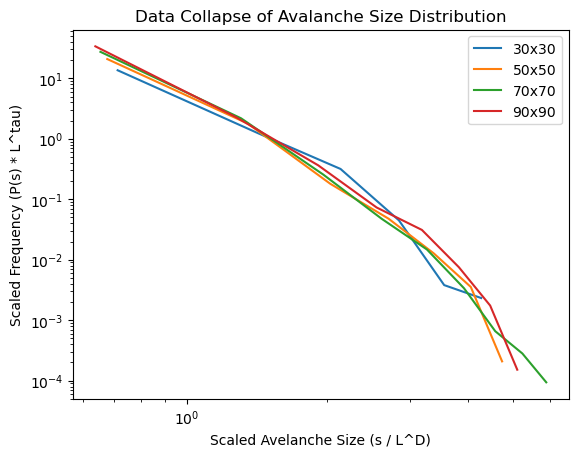

In [28]:
scaled_sizes = []
scaled_frequencies = []
D = 0.1
tau = 0.8

for sizes, frequencies, side in zip(all_sizes, all_frequencies, side_lenght):
    scaled_sizes.append(sizes / (side ** D))
    scaled_frequencies.append(frequencies * (side ** tau))

for scaled_size, scaled_frequency, side in zip(scaled_sizes, scaled_frequencies, side_lenght):
    plt.plot(scaled_size, scaled_frequency, label=f'{side}x{side}')

plt.title('Data Collapse of Avalanche Size Distribution')
plt.xlabel('Scaled Avelanche Size (s / L^D)')
plt.ylabel('Scaled Frequency (P(s) * L^tau)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()